In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Dense, MaxPool2D, LeakyReLU, Reshape, Dropout, Flatten, GaussianNoise
from tensorflow.keras.losses import BinaryCrossentropy, MSE
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import time

In [2]:
def normalize_img(img):
    return (img - 127.5)/127.5

def unnormalize_img(img):
    return (img + 1.) / 2.

In [3]:
train_imgs = []
import os
for root, dirs, files in os.walk("./CUB_200_2011/CUB_200_2011/images-cleaned/", topdown=False):
    for name in files:
        train_imgs.append(cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_RGB2BGR))

train_imgs = np.array(train_imgs)
train_imgs = (train_imgs - 127.5)/127.5

In [4]:
def make_generator_model_mse(shape):
    
    input_layer = Input(shape=shape)
    
    x = Dense(8*8*64)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((8, 8, 64))(x)
    
    x = Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model(input_layer, x)

In [5]:
def make_discriminator_model_mse():
    input_layer = Input((64, 64, 3))
    
    x = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(1)(x)
    
    return Model(input_layer, x)

In [6]:
def make_generator_model_deeper(shape):
    
    input_layer = Input(shape=shape)
    
    x = Dense(16*16*64)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((16, 16, 64))(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model(input_layer, x)

In [7]:
def make_discriminator_model_deeper():
    input_layer = Input((64, 64, 3))
    x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Dense(1)(x)
    
    return Model(input_layer, x)

In [10]:
deeper_g_200z = make_generator_model_deeper(200)
deeper_g_100z = make_generator_model_deeper(100)
mse_g = make_generator_model_mse(200)

In [11]:
deeper_g_200z.load_weights('./results/weights/bird-gan-deeper/gen_weights_deeper_4000.h5')
deeper_g_100z.load_weights('./results/weights/bird-gan-deeper-smaller-z/gen_weights_deeper_smaller_z_4000.h5')
mse_g.load_weights('./results/weights/bird-gan-mse/gen_weights_mse_3900.h5')

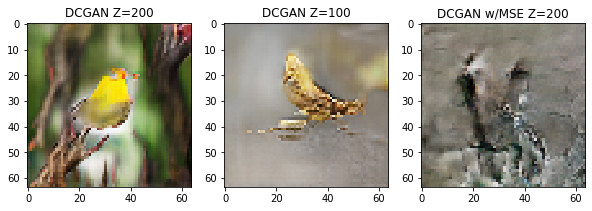

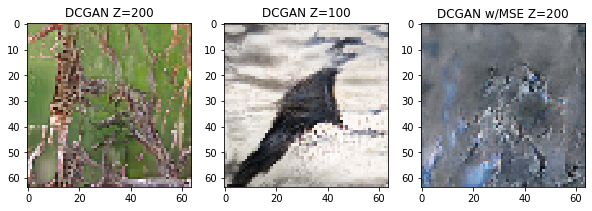

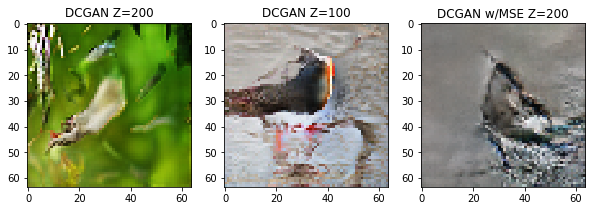

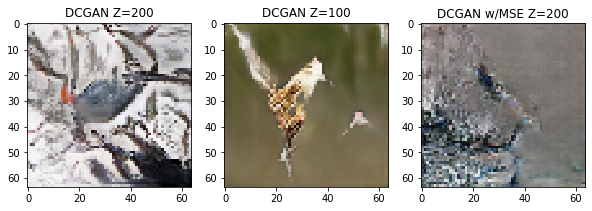

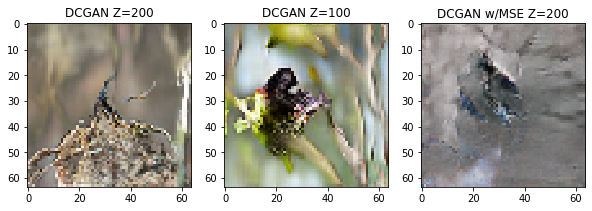

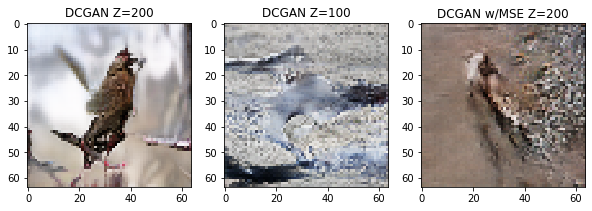

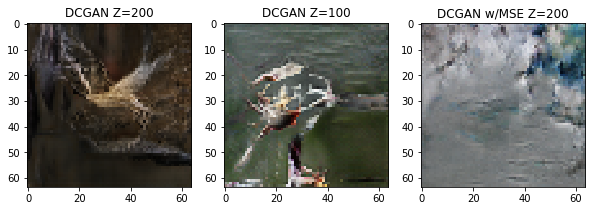

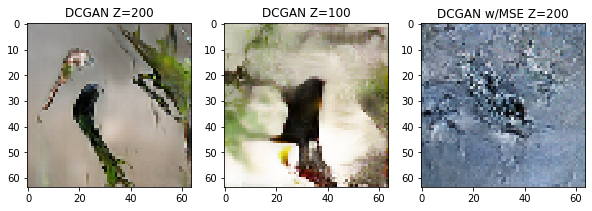

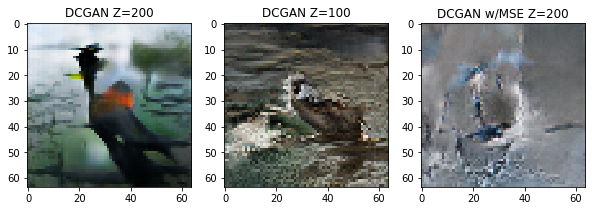

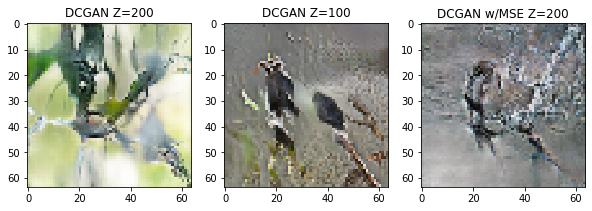

In [19]:
for i in range(10):
    noise200 = np.random.normal(0, 1, 200)
    noise100 = noise200[:100]
    
    deeper_image_200z = deeper_g_200z.predict(np.array([noise200]))[0]
    deeper_image_100z = deeper_g_100z.predict(np.array([noise100]))[0]
    mse_image = mse_g.predict(np.array([noise200]))[0]
    
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(131)
    ax1.imshow(unnormalize_img(deeper_image_200z))
    ax2 = fig.add_subplot(132)
    ax2.imshow(unnormalize_img(deeper_image_100z))
    ax3 = fig.add_subplot(133)
    ax3.imshow(unnormalize_img(mse_image))
    ax1.title.set_text('DCGAN Z=200')
    ax2.title.set_text('DCGAN Z=100')
    ax3.title.set_text('DCGAN w/MSE Z=200')
    plt.show()